<a href="https://colab.research.google.com/github/RosarioH10062002/eeg-structural-analysis-attention-ml/blob/main/ADHD_ML_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Research question**
Do EEG frequency-band features (delta, alpha, beta/TBR) that differentiate attentional states in labeled Fpz–Pz data exhibit consistent structural organization when extracted from unlabeled multi-channel EEG under different stimulation conditions?

#**LIBRARIES**

In [109]:
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')
import os
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
import umap

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#**DATA UPLOAD**

In [11]:
#@title 64 channels
path_64_mono = "/content/drive/My Drive/Desktop Uni/Project_ML/Dr. Axel_Hutt/EEG_mono_64.dat"
path_64_noise = "/content/drive/My Drive/Desktop Uni/Project_ML/Dr. Axel_Hutt/EEG_noise_64.dat"

df_64_mono = pd.read_csv(path_64_mono,delim_whitespace=True, header=None)
df_64_noise = pd.read_csv(path_64_noise,delim_whitespace=True, header=None)
columns = ["Time"] + [f"Channel {n}" for n in range(1,65)]
df_64_mono.columns = columns
df_64_noise.columns = columns

/tmp/ipython-input-1466872255.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_64_mono = pd.read_csv(path_64_mono,delim_whitespace=True, header=None)
/tmp/ipython-input-1466872255.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_64_noise = pd.read_csv(path_64_noise,delim_whitespace=True, header=None)


In [71]:
#@title 6 channels
path_6_features_mono = "/content/drive/My Drive/Desktop Uni/Project_ML/real_6eeg/EEG_mono.dat"
path_6_features_noise = "/content/drive/My Drive/Desktop Uni/Project_ML/real_6eeg/EEG_noise.dat"

df_6_mono = pd.read_csv(path_6_features_mono,delim_whitespace=True, header=None)
df_6_noise = pd.read_csv(path_6_features_noise,delim_whitespace=True, header=None)
columns = ["Time"] + [f"Channel {x}" for x in range(1,7)]
df_6_mono.columns = columns
df_6_noise.columns = columns
df_6_mono

/tmp/ipython-input-2166192297.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_6_mono = pd.read_csv(path_6_features_mono,delim_whitespace=True, header=None)
/tmp/ipython-input-2166192297.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_6_noise = pd.read_csv(path_6_features_noise,delim_whitespace=True, header=None)


,Time,Channel 1,Channel 2,Channel 3,Channel 4,Channel 5,Channel 6
0,0.000000,-7.623300e-21,0.000000e+00,2.541100e-21,-1.185850e-20,5.082200e-21,1.084200e-19
1,0.000488,-4.046590e-07,-4.184110e-07,-3.712030e-07,4.699270e-08,-3.869680e-07,1.718130e-06
2,0.000977,-8.076960e-07,-8.351900e-07,-7.410060e-07,9.443270e-08,-7.724850e-07,3.432170e-06
3,0.001465,-1.207470e-06,-1.248690e-06,-1.107980e-06,1.428000e-07,-1.155070e-06,5.138050e-06
4,0.001953,-1.602460e-06,-1.657400e-06,-1.470840e-06,1.924680e-07,-1.533390e-06,6.831660e-06
...,...,...,...,...,...,...,...
1947643,950.998047,-3.840260e-07,-6.504340e-07,-4.952680e-07,4.762040e-07,8.594440e-08,3.868250e-07
1947644,950.998535,-2.898470e-07,-4.895660e-07,-3.733140e-07,3.572340e-07,6.406670e-08,2.905960e-07
1947645,950.999023,-1.941420e-07,-3.272420e-07,-2.498020e-07,2.381580e-07,4.248510e-08,1.939260e-07
1947646,950.999512,-9.738030e-08,-1.639130e-07,-1.252140e-07,1.190490e-07,2.113930e-08,9.698970e-08


In [52]:
#@title 2 channels
path_2_features_ctrl_1 = "/content/drive/My Drive/Desktop Uni/Project_ML/Dr. Axel_Hutt/Data for new task/FpzPz_delta_ctrl.dat"
path_2_features_ctrl_2 = "/content/drive/My Drive/Desktop Uni/Project_ML/Dr. Axel_Hutt/Data for new task/FpzPz_alpha_ctrl.dat"
path_2_features_ctrl_3 = "/content/drive/My Drive/Desktop Uni/Project_ML/Dr. Axel_Hutt/Data for new task/FpzPz_thetabeta_ctrl.dat"

path_2_features_inatt_1 = "/content/drive/My Drive/Desktop Uni/Project_ML/Dr. Axel_Hutt/Data for new task/FpzPz_delta_inattention.dat"
path_2_features_inatt_2 = "/content/drive/My Drive/Desktop Uni/Project_ML/Dr. Axel_Hutt/Data for new task/FpzPz_alpha_inattention.dat"
path_2_features_inatt_3 = "/content/drive/My Drive/Desktop Uni/Project_ML/Dr. Axel_Hutt/Data for new task/FpzPz_thetabeta_inattention.dat"

df_2_ctrl_1 = pd.read_csv(path_2_features_ctrl_1, sep = "\t", header = None)
df_2_ctrl_2 = pd.read_csv(path_2_features_ctrl_2, sep = "\t", header = None)
df_2_ctrl_3 = pd.read_csv(path_2_features_ctrl_3, sep = "\t", header = None)

df_2_ctrl = pd.concat([df_2_ctrl_1, df_2_ctrl_2, df_2_ctrl_3], axis=1)

df_2_inatt_1 = pd.read_csv(path_2_features_inatt_1, sep = "\t", header = None)
df_2_inatt_2 = pd.read_csv(path_2_features_inatt_2, sep = "\t", header = None)
df_2_inatt_3 = pd.read_csv(path_2_features_inatt_3, sep = "\t", header = None)

df_2_inatt = pd.concat([df_2_inatt_1, df_2_inatt_2, df_2_inatt_3], axis=1)

columns = ["Fpz delta", "Pz delta", "Fpz alpha", "Pz alpha", "Fpz TBR", "Pz TBR"]
df_2_ctrl.columns = columns
df_2_inatt.columns = columns

In [63]:
df_2_ctrl

,Fpz delta,Pz delta,Fpz alpha,Pz alpha,Fpz TBR,Pz TBR
0,7.501290e-12,8.765130e-12,6.249510e-13,7.801930e-13,7.252080,9.374660
1,1.363970e-10,1.932490e-11,7.664220e-13,4.433110e-13,11.604200,15.776900
2,3.232000e-11,2.882610e-11,5.080230e-13,5.398150e-13,11.635800,17.495100
3,1.911690e-11,4.123790e-12,1.218790e-12,1.234540e-12,6.559600,6.012440
4,1.684250e-11,7.989630e-12,9.154670e-13,9.701400e-13,12.643500,15.742100
...,...,...,...,...,...,...
331,1.227520e-10,1.025650e-10,4.335200e-12,2.736910e-12,1.089350,1.658670
332,4.942950e-10,1.996850e-11,4.670730e-12,3.380300e-12,1.793670,1.800420
333,2.078340e-10,5.132120e-11,2.843690e-12,2.498870e-12,0.708902,1.230970
334,8.764010e-11,8.124430e-11,3.088440e-12,2.096270e-12,0.331479,0.667056


In [86]:
#@title Final data
final_path = "/content/drive/My Drive/Desktop Uni/Project_ML/Dr. Axel_Hutt/final_data/"
def save_data(name, file_name):
  file_name.to_csv(final_path + f"{name}.csv", index = False)
save_data("df_2_ctrl",df_2_ctrl)
save_data("df_2_inatt",df_2_inatt)
save_data("df_6_mono",df_6_mono)
save_data("df_6_noise",df_6_noise)
#save_data("df_64_mono",df_64_mono)
#save_data("df_64_noise", df_64_noise)

In [81]:
def load_data(name):
  df = pd.read_csv(final_path + f"{name}.csv")
  return df

#**Attention vs Inattention Linear Classifiers**
Evaluate whether attentional states (attention vs inattention) are separable using a minimal EEG feature representation derived from Fpz–Pz spectral features.

In [95]:
df_2_ctrl = load_data("df_2_ctrl")
df_2_inatt = load_data("df_2_inatt")
df_2_ctrl["label"] = 0      # attention
df_2_inatt["label"] = 1     # inattention

df = pd.concat([df_2_ctrl, df_2_inatt], axis=0).reset_index(drop=True)

X = df.drop(columns=["label"])
y = df["label"].values

<Figure size 2000x600 with 0 Axes>

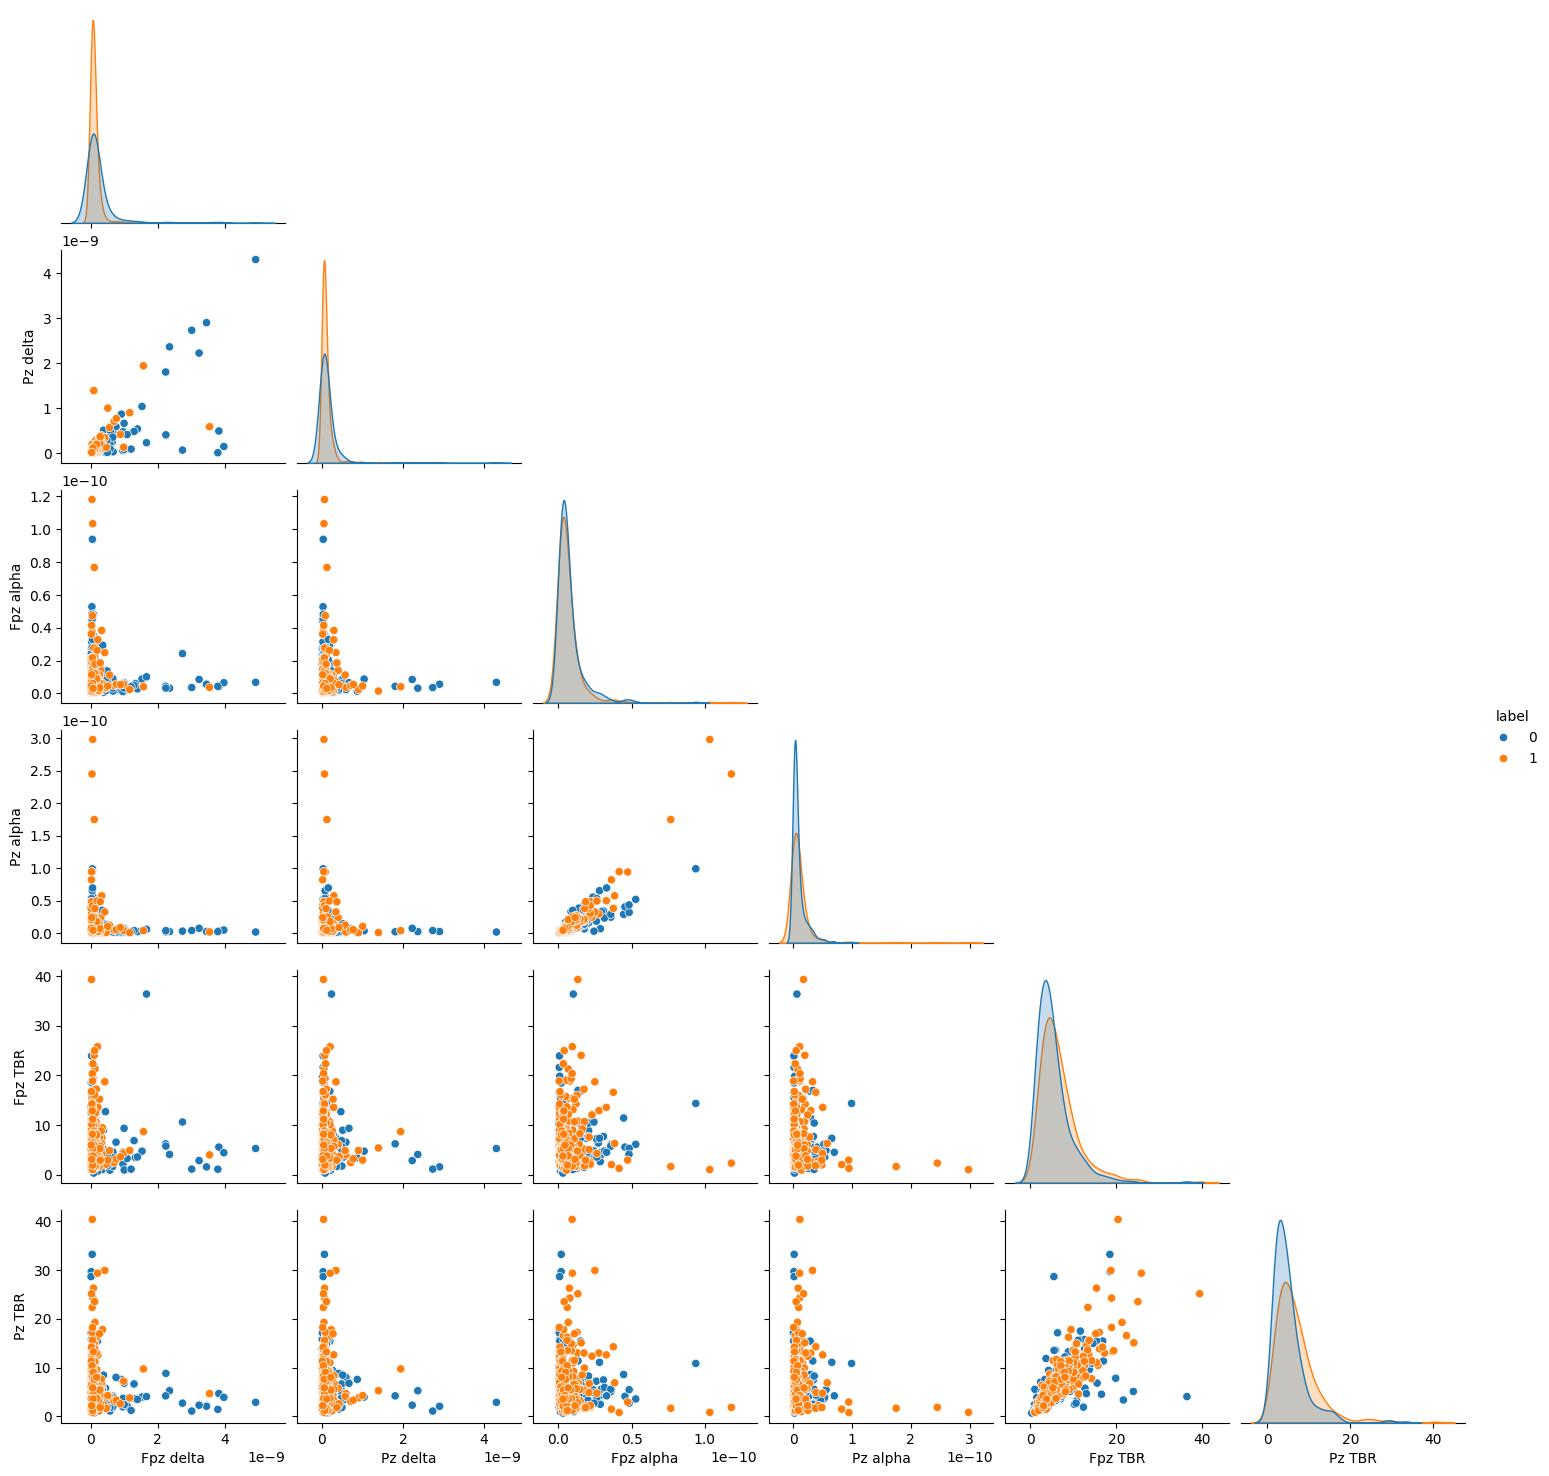

In [111]:
plt.figure(figsize=(20, 6))
sns.pairplot(
    df,
    vars=["Fpz delta", "Pz delta",
          "Fpz alpha", "Pz alpha",
          "Fpz TBR", "Pz TBR"],
    hue="label",
    corner=True
)
plt.show()

Fpz and Pz theta/beta ratio are informative candidate markers that reflect subtle, coupled changes associated with attentional state, but are insufficient in isolation for robust classification.

In [96]:
#Z-score normalization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

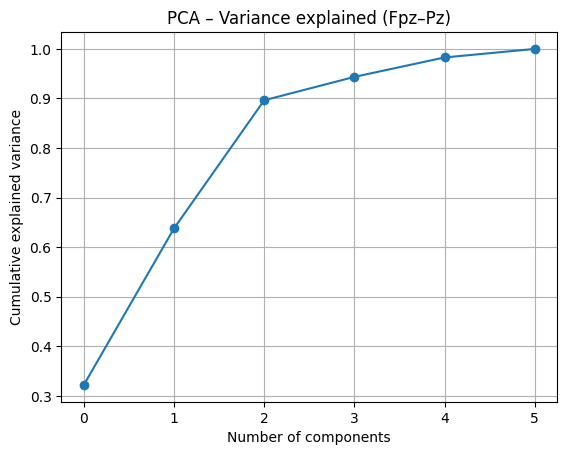

In [100]:
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure()
plt.plot(explained_variance, marker="o")
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.title("PCA – Variance explained (Fpz–Pz)")
plt.grid()
plt.show()

In [102]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [103]:
logreg = LogisticRegression(
    penalty="l2",
    class_weight="balanced",
    max_iter=1000
)

acc_logreg = cross_val_score(
    logreg, X_scaled, y, cv=cv, scoring="accuracy"
)

f1_logreg = cross_val_score(
    logreg, X_scaled, y, cv=cv, scoring="f1"
)

print("Logistic Regression")
print("Accuracy:", acc_logreg.mean(), "±", acc_logreg.std())
print("F1-score:", f1_logreg.mean(), "±", f1_logreg.std())


Logistic Regression
Accuracy: 0.6460097154753643 ± 0.03755398583409677
F1-score: 0.6396086701089427 ± 0.03912819261366391


In [104]:
svm = SVC(
    kernel="linear",
    class_weight="balanced"
)

acc_svm = cross_val_score(
    svm, X_scaled, y, cv=cv, scoring="accuracy"
)

f1_svm = cross_val_score(
    svm, X_scaled, y, cv=cv, scoring="f1"
)

print("\nLinear SVM")
print("Accuracy:", acc_svm.mean(), "±", acc_svm.std())
print("F1-score:", f1_svm.mean(), "±", f1_svm.std())



Linear SVM
Accuracy: 0.6262664816099931 ± 0.04170836662482779
F1-score: 0.6103574754149593 ± 0.05938781360099434


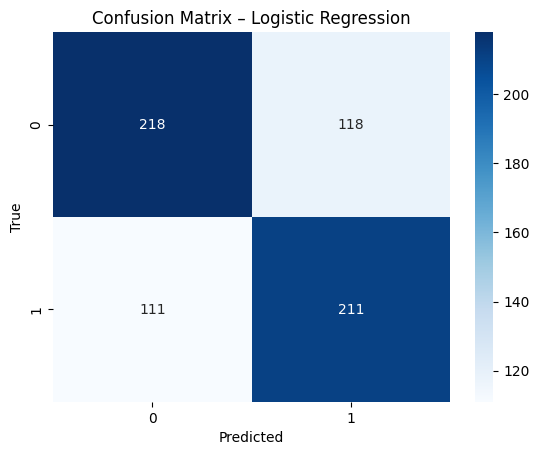

In [105]:
# Fit on full dataset (for inspection only)
logreg.fit(X_scaled, y)
y_pred = logreg.predict(X_scaled)

cm = confusion_matrix(y, y_pred)

plt.figure()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix – Logistic Regression")
plt.show()


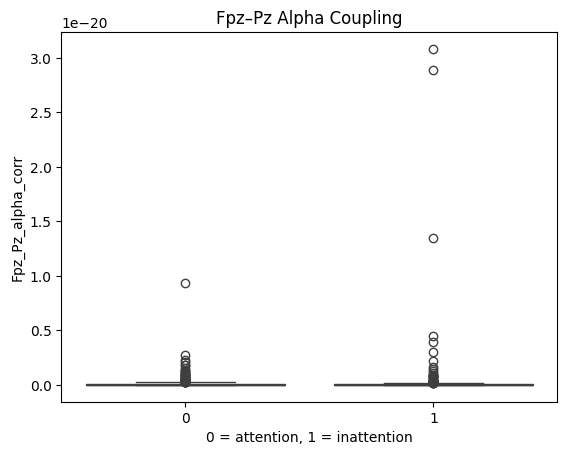

In [107]:
df["Fpz_Pz_delta_corr"] = df["Fpz delta"] * df["Pz delta"]
df["Fpz_Pz_alpha_corr"] = df["Fpz alpha"] * df["Pz alpha"]
df["Fpz_Pz_TBR_corr"]   = df["Fpz TBR"]   * df["Pz TBR"]

sns.boxplot(
    data=df,
    x="label",
    y="Fpz_Pz_alpha_corr"
)
plt.xlabel("0 = attention, 1 = inattention")
plt.title("Fpz–Pz Alpha Coupling")
plt.show()


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


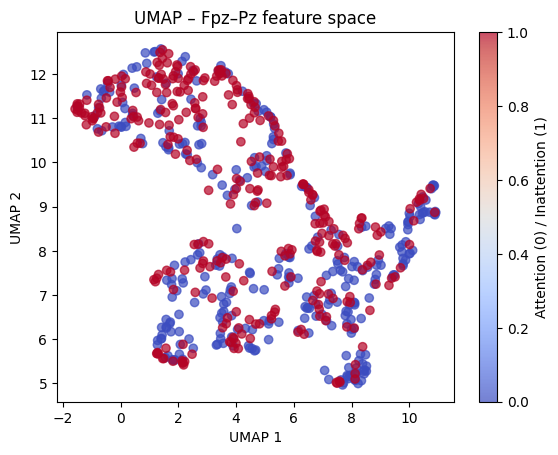

In [108]:
reducer = umap.UMAP(random_state=42)
X_umap = reducer.fit_transform(X_scaled)

plt.figure()
plt.scatter(
    X_umap[:, 0],
    X_umap[:, 1],
    c=y,
    cmap="coolwarm",
    alpha=0.7
)
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.title("UMAP – Fpz–Pz feature space")
plt.colorbar(label="Attention (0) / Inattention (1)")
plt.show()


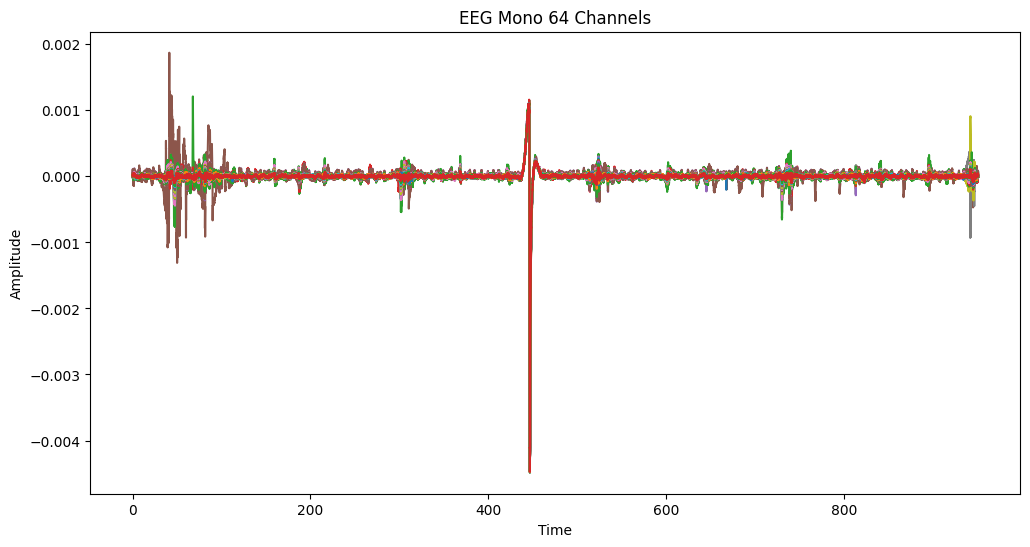

In [38]:
plt.figure(figsize=(12, 6))
x_data = df_64_mono['Time']
for channel_idx in range(1, df_64_mono.shape[1]):
  plt.plot(x_data, df_64_mono.iloc[:, channel_idx])

plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("EEG Mono 64 Channels")
plt.show()

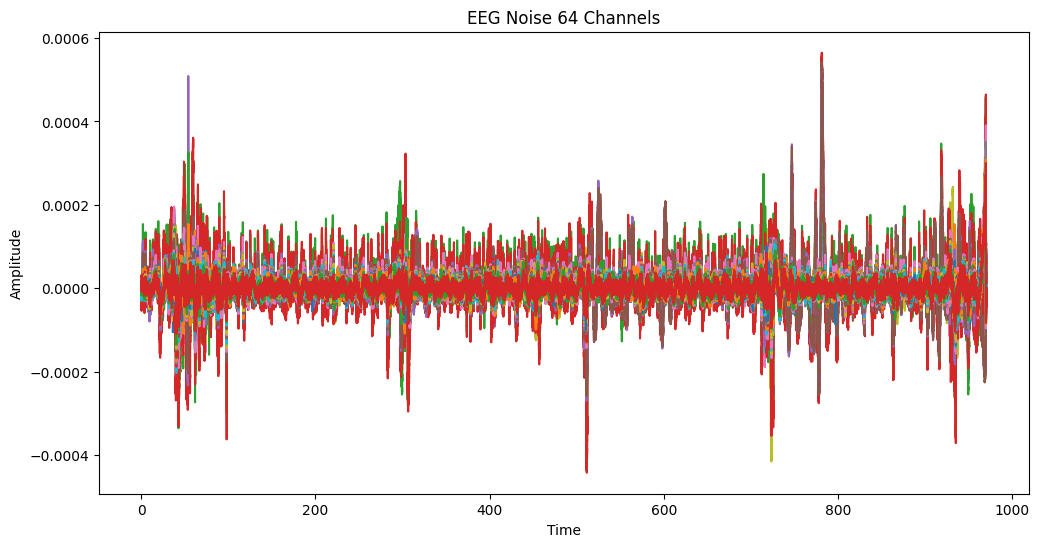

In [37]:
plt.figure(figsize=(12, 6))
x_data = df_64_noise['Time']
for channel_idx in range(1, df_64_noise.shape[1]):
  plt.plot(x_data, df_64_noise.iloc[:, channel_idx])

plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("EEG Noise 64 Channels")
plt.show()

#**PCA**